# Traffic Sign Classification using NN

- Author: Yiran Jing
- Date: Nov 2020
- Group: CP32-17b1 (COMP3988 group 1)

Our model can classify the input images (collected by the donkey car) into 5 main classes:
- right-turining (including blue, black-turning sign)
- left-turining (including blue, black-turning sign)
- stop
- speed_50_white
- park (yellow and green)


## Content 
1. **Obstract interested area (detect based on color) using openCV**
1. **EDA**
2. **Feature Engineering**
    1. Configure the dataset for performance (all 100 * 100)
    2. Standardize the data
3. **Train model**
    1. 20% as test data, 80% as train data
    2. three convolution blocks
4. **Model evaluation**
    1. Confusion Matrix
    2. Classification report for each class
         - The overall TEST accuracy is 100%. The model performances very good overall.
***
### Dataset description
The data within folder `data`, and the data was collectted by donkey car simulator given by different drivers

**Note**: current dataset is unbalanced (too few images in some classes). So the current model result is unreliable. 
- **Train data**: 
The total number of turning images are (4929). 
- stop: 428 images.
- right: 1223 images.
- left: 1800 images.
- park: 768 images.
- speed_50_white: 710 images.

- **Test data**:
The total number of test images are (812). 
- stop: 23 images.
- right: 130 images.
- left: 299 images.
- park: 322 images.
- speed_50_white: 38 images.


- Within the train data, we separate 20% data as the validation data to estimate the hyper-parameter turning and avoid overfitting. 
***
   
### Benefits of current CNN model

1. **The model is relatively ROBUST: not sensitive to the environment noise.
1. Our current CNN model has simple structure
2. The model training is fast (around 3 mins using CPU)
3. Can get real-time prediction with no delay, and thus, the car can take action immediately after detected the sign. 

In [2]:
import matplotlib.pyplot as plt
from os import listdir, rename, listdir
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
import tempfile
import cv2
import numpy as np
import platform
import time
import sys
import shutil
import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from TFmodel_helper_function import *
from Object_Detection_Unity import *



### Load dataset and visualization

In [11]:
folder = "data"
labels = ['left', 'park', 'right', 'speed_50_white', 'stop']

### Original dataset size

In [6]:
# load dataset
data_dir = load_training_data(folder, "/train")
print("--------------------------------------------")
test_data_dir = load_testing_data(folder, "/test")

Train data: 
The total number of turning images are 9954. 

left: 3265 images.
park: 3308 images.
right: 2265 images.
speed_50_white: 754 images.
stop: 362 images.
--------------------------------------------
Test data:
The total number of test images are 2339. 

left: 713 images.
park: 1035 images.
right: 426 images.
speed_50_white: 141 images.
stop: 24 images.


# OpenCV pre-processing 

Note that if the images fail to be detected using OpenCV, then they willnot be collected by roi output folder. And thus willnot be used to train model.

We are trying to guarantee the high detection rate using openCV for each class

In [7]:
abs_path = "data/"

train_path = abs_path + "train/" # the path of original training images
test_path = abs_path + "test/" # the path of original test images
roi_train_path = abs_path + "trainCNN_roi/" # the path of the training rois after openCV processing
roi_test_path = abs_path + "testCNN_roi/" # the path of the test rois after openCV processing
fail_openCV = abs_path + "fail_openCV/" # the path used to collect failed image

### define the target folder we want to use to collect data

In [8]:
class_names = ["stop/stop_simulator/", "stop/stop_realWorld/", 
                 "right/right_blue/", "right/right_realWorldImage/", "right/right_black/",
                 "left/left_blue/", "left/left_real_worldImage/", "left/left_black/", "left/left_blue_f1/",
                "park/park_green/", "park/park_yellow/", #"park/park_white/",
                 "speed_50_white/speed_50_white_simulator/", "speed_50_white/speed_50_realworldImage/",
                 #"other/other_simulator/"
                ]

In [ ]:
%time 
"""
OpenCV processing

"""

for folder_name in class_names:
    
    # process training images
    class_train_path = train_path + folder_name
    roi_dst_dir = roi_train_path + folder_name
    #print(class_train_path)
    fail_image_collection, success_rate = test_images(class_train_path, roi_dst_dir, 0)
    print("The success rate on {} training images is : {:.3f}".format(folder_name, success_rate))
    
    # process testing images
    if "world" or "f1" in folder_name.lower(): # the images of real world or f1 track are only in training dataset
        continue # the testing dataset has no realworld images currently
    class_test_path = test_path + folder_name
    roi_dst_dir = roi_test_path + folder_name
    fail_image_collection, success_rate = test_images(class_test_path, roi_dst_dir, 0)
    print("The success rate on {} test images is : {:.3f}".format(folder_name, success_rate))

## Data processed by openCV for CNN model training
The data in the folder `trainfilterCNN_roi` and `testfilterCNN_roi` are the selected roi from `trainCNN_roi` and `testCNN_roi`folder

In [12]:
# the folder of mannully cleaned dataset, which will be used to train model.
trainCNN_roi = "/trainfilterCNN_roi" # the roi image folder including iamges had been manually filltered
testCNN_roi = "/testfilterCNN_roi" # the folder name of testing roi images images 

# remove other 
#labels = ["stop/stop_simulator", "right/right_blue", "right/right_black", "left/left_blue", 
          #"left/left_black", "left/left_blue_f1", "park/park_yellow", "park/park_green", "speed_50_white/speed_50_white_simulator"]


In [13]:
"""
images will be used to train and test data
"""
data_dir = load_training_data(folder, trainCNN_roi)
test_data_dir = load_testing_data(folder, testCNN_roi)

Train data: 
The total number of turning images are 4855. 

left: 1869 images.
park: 768 images.
right: 1080 images.
speed_50_white: 710 images.
stop: 428 images.
Test data:
The total number of test images are 886. 

left: 373 images.
park: 322 images.
right: 130 images.
speed_50_white: 38 images.
stop: 23 images.


# CNN model

In [14]:
# Predefined CNN model Hyper-parameter 
learning_rate = 0.001
batch_size = 64
img_height = 100
img_width = 100
epochs = 8


In [15]:
# split training, validation and testing dataset
train_ds, val_ds, test_ds = separate_train_val_test_data(data_dir, test_data_dir)
    
class_names = train_ds.class_names
print("The class will be used to train CNN models are:")
print(class_names) 

Found 4842 files belonging to 5 classes.
Using 3874 files for training.
Found 4842 files belonging to 5 classes.
Using 968 files for validation.
Found 878 files belonging to 5 classes.
The class will be used to train CNN models are:
['left', 'park', 'right', 'speed_50_white', 'stop']


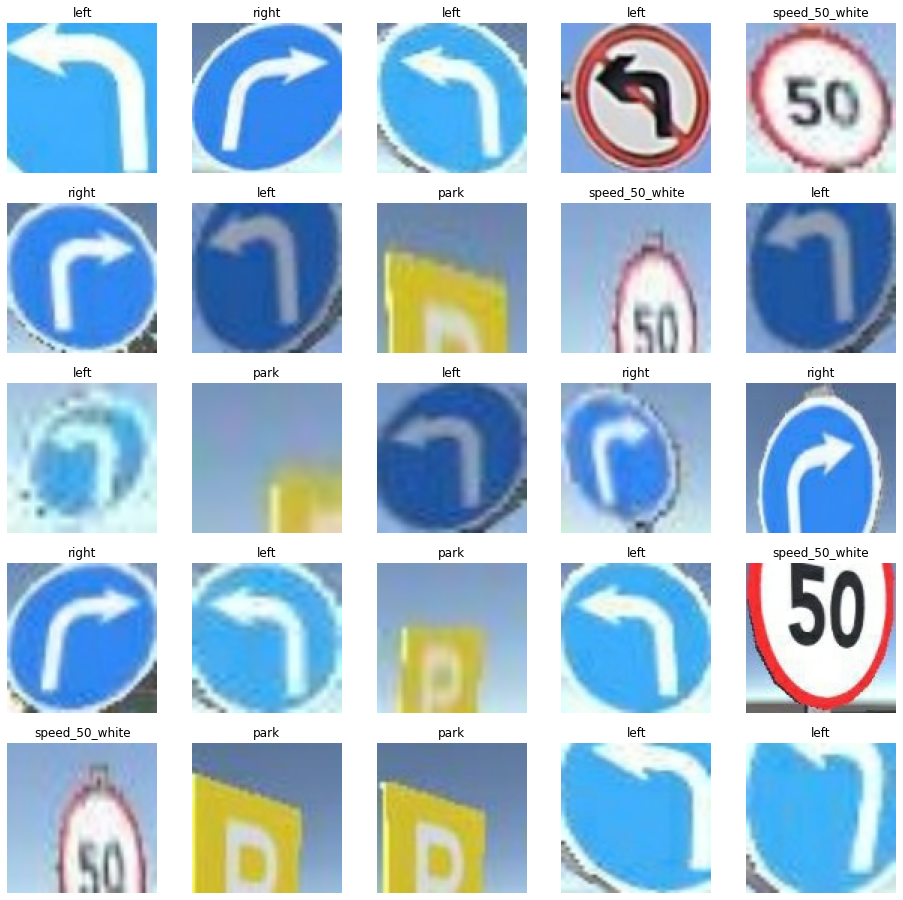

In [16]:
## visualize some training data
visualization_training_data(train_ds)

In [17]:
# Feature Engineering
train_ds, val_ds, test_ds = dataset_config(train_ds, val_ds, test_ds)
    
# Train Model
cnn, cnn_history = train_visualize_CNN(epochs, train_ds, val_ds)

Epoch 1/8
61/61 [==============================] - 24s 390ms/step - loss: 0.6198 - accuracy: 0.7736 - val_loss: 0.2237 - val_accuracy: 0.9287
Epoch 2/8
61/61 [==============================] - 22s 369ms/step - loss: 0.1363 - accuracy: 0.9528 - val_loss: 0.1156 - val_accuracy: 0.9556
Epoch 3/8
61/61 [==============================] - 23s 375ms/step - loss: 0.0732 - accuracy: 0.9770 - val_loss: 0.0767 - val_accuracy: 0.9752
Epoch 4/8
61/61 [==============================] - 23s 378ms/step - loss: 0.0374 - accuracy: 0.9899 - val_loss: 0.0480 - val_accuracy: 0.9845
Epoch 5/8
61/61 [==============================] - 25s 418ms/step - loss: 0.0252 - accuracy: 0.9920 - val_loss: 0.0888 - val_accuracy: 0.9731
Epoch 6/8
61/61 [==============================] - 24s 399ms/step - loss: 0.0360 - accuracy: 0.9874 - val_loss: 0.0395 - val_accuracy: 0.9897


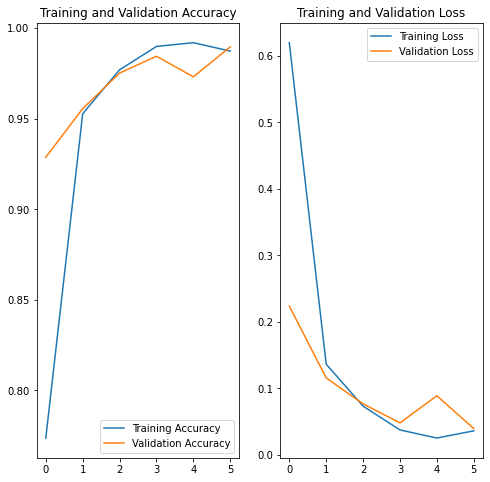

In [18]:
# Visualize CNN model results
plot_train_result(cnn_history, epochs)

Confusion Matrix, x label is Predicted_Label, y is True_Label


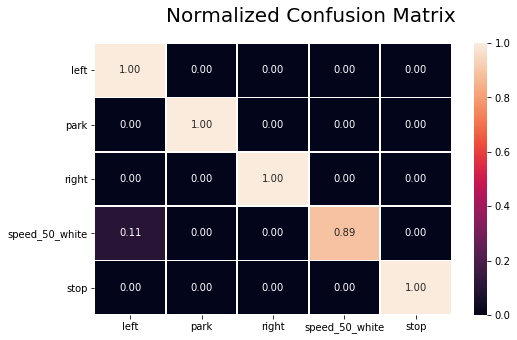

Classification Report bazed on test data
                precision    recall  f1-score   support

          left       0.99      1.00      0.99       370
          park       1.00      1.00      1.00       320
         right       1.00      1.00      1.00       128
speed_50_white       1.00      0.89      0.94        37
          stop       1.00      1.00      1.00        23

      accuracy                           0.99       878
     macro avg       1.00      0.98      0.99       878
  weighted avg       0.99      0.99      0.99       878



In [19]:
draw_confusion_matrix(cnn, test_ds, class_names)

In [20]:
# save model
cnn.save('../../model/sign.h5')

# Test other dataset

The total number of test images are 3022. 

Found 3021 files belonging to 5 classes.
Confusion Matrix, x label is Predicted_Label, y is True_Label


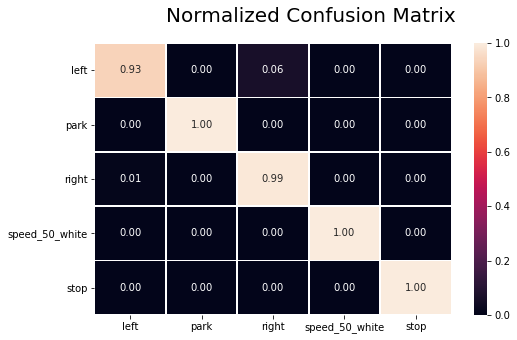

Classification Report bazed on test data
                precision    recall  f1-score   support

          left       0.99      0.93      0.96       605
          park       1.00      1.00      1.00       765
         right       0.94      0.99      0.96       585
speed_50_white       1.00      1.00      1.00       707
          stop       1.00      1.00      1.00       359

      accuracy                           0.98      3021
     macro avg       0.98      0.98      0.98      3021
  weighted avg       0.99      0.98      0.98      3021



In [29]:
test_data_dir = pathlib.Path("../../tests/track1")
image_count = len(list(test_data_dir.glob('*/*/*'))) # there are some png, also some jpg
print("The total number of test images are {}. \n".format(image_count))

# process data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir, 
  image_size=(img_height, img_width),
  seed=123, 
  batch_size=batch_size)
labels = test_ds.class_names

AUTOTUNE = tf.data.experimental.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# draw confusion matrix
draw_confusion_matrix(cnn, test_ds, class_names = labels)

The total number of test images are 812. 

Found 805 files belonging to 5 classes.
Confusion Matrix, x label is Predicted_Label, y is True_Label


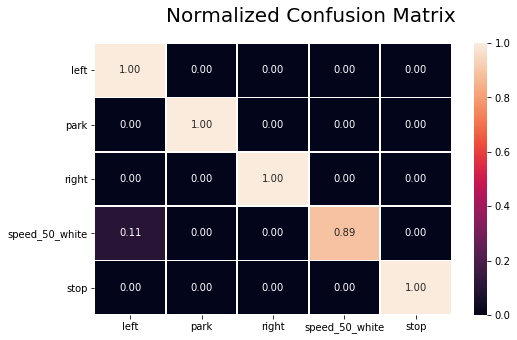

Classification Report bazed on test data
                precision    recall  f1-score   support

          left       0.98      1.00      0.99       297
          park       1.00      1.00      1.00       320
         right       1.00      1.00      1.00       128
speed_50_white       1.00      0.89      0.94        37
          stop       1.00      1.00      1.00        23

      accuracy                           0.99       805
     macro avg       1.00      0.98      0.99       805
  weighted avg       0.99      0.99      0.99       805



In [30]:
test_data_dir = pathlib.Path("../../tests/track2")
image_count = len(list(test_data_dir.glob('*/*/*'))) # there are some png, also some jpg
print("The total number of test images are {}. \n".format(image_count))

# process data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir, 
  image_size=(img_height, img_width),
  seed=123, 
  batch_size=batch_size)
labels = test_ds.class_names

AUTOTUNE = tf.data.experimental.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# draw confusion matrix
draw_confusion_matrix(cnn, test_ds, class_names = labels)

# Test and visualization misclassification images

### Show park images have miscalssification

In [31]:
roi_test_path = "../../tests/track1/right/right_blue/" # test track 1 
test_missclassification_images('right', cnn, roi_test_path,  class_names, 
                               CI_level = 20, 
                               display_misclassification_images = True)

Image: 5302_cam-image_array_.jpg
True class:  right
Predicted class: left





Image: 5777_cam-image_array_.jpg
True class:  right
Predicted class: left





Image: 5301_cam-image_array_.jpg
True class:  right
Predicted class: left





Image: 5776_cam-image_array_.jpg
True class:  right
Predicted class: left





Image: 5300_cam-image_array_.jpg
True class:  right
Predicted class: left





Test 550 images on class right, misclassification ratio is 0.01


In [ ]:
roi_test_path = "data/testfilterCNN_roi/park/park_yellow/"
test_missclassification_images('park', cnn, roi_test_path,  class_names, 
                               CI_level = 20, 
                               display_misclassification_images = True)

### Test the model performance on the images without traffic sign

In [ ]:
roi_test_path = "data/test_other_unity/" # images without traffic sign
test_missclassification_images('other', cnn, roi_test_path,  
                               class_names, CI_level = 99, 
                               display_misclassification_images = True)

In [ ]:
roi_test_path = "data/test_other_shenzhen/"
test_missclassification_images('other', cnn, roi_test_path,  class_names, 
                               CI_level = 99, 
                               display_misclassification_images = True)